# Donors Choose Application Screening

<p>
DonorsChoose.org receives hundreds of thousands of project proposals each year for classroom projects in need of funding. Right now, a large number of volunteers is needed to manually screen each submission before it's approved to be posted on the DonorsChoose.org website.
</p>
<p>
    Next year, DonorsChoose.org expects to receive close to 500,000 project proposals. As a result, there are three main problems they need to solve:
<ul>
<li>
    How to scale current manual processes and resources to screen 500,000 projects so that they can be posted as quickly and as efficiently as possible</li>
    <li>How to increase the consistency of project vetting across different volunteers to improve the experience for teachers</li>
    <li>How to focus volunteer time on the applications that need the most assistance</li>
    </ul>
</p>    
<p>
The goal of the competition is to predict whether or not a DonorsChoose.org project proposal submitted by a teacher will be approved, using the text of project descriptions as well as additional metadata about the project, teacher, and school. DonorsChoose.org can then use this information to identify projects most likely to need further review before approval.
</p>

## About the DonorsChoose Data Set

The `train.csv` data set provided by DonorsChoose contains the following features:

Feature | Description 
----------|---------------
**`project_id`** | A unique identifier for the proposed project. **Example:** `p036502`   
**`project_title`**    | Title of the project. **Examples:**<br><ul><li><code>Art Will Make You Happy!</code></li><li><code>First Grade Fun</code></li></ul> 
**`project_grade_category`** | Grade level of students for which the project is targeted. One of the following enumerated values: <br/><ul><li><code>Grades PreK-2</code></li><li><code>Grades 3-5</code></li><li><code>Grades 6-8</code></li><li><code>Grades 9-12</code></li></ul>  
 **`project_subject_categories`** | One or more (comma-separated) subject categories for the project from the following enumerated list of values:  <br/><ul><li><code>Applied Learning</code></li><li><code>Care &amp; Hunger</code></li><li><code>Health &amp; Sports</code></li><li><code>History &amp; Civics</code></li><li><code>Literacy &amp; Language</code></li><li><code>Math &amp; Science</code></li><li><code>Music &amp; The Arts</code></li><li><code>Special Needs</code></li><li><code>Warmth</code></li></ul><br/> **Examples:** <br/><ul><li><code>Music &amp; The Arts</code></li><li><code>Literacy &amp; Language, Math &amp; Science</code></li>  
  **`school_state`** | State where school is located ([Two-letter U.S. postal code](https://en.wikipedia.org/wiki/List_of_U.S._state_abbreviations#Postal_codes)). **Example:** `WY`
**`project_subject_subcategories`** | One or more (comma-separated) subject subcategories for the project. **Examples:** <br/><ul><li><code>Literacy</code></li><li><code>Literature &amp; Writing, Social Sciences</code></li></ul> 
**`project_resource_summary`** | An explanation of the resources needed for the project. **Example:** <br/><ul><li><code>My students need hands on literacy materials to manage sensory needs!</code</li></ul> 
**`project_essay_1`**    | First application essay<sup>*</sup>  
**`project_essay_2`**    | Second application essay<sup>*</sup> 
**`project_essay_3`**    | Third application essay<sup>*</sup> 
**`project_essay_4`**    | Fourth application essay<sup>*</sup> 
**`project_submitted_datetime`** | Datetime when project application was submitted. **Example:** `2016-04-28 12:43:56.245`   
**`teacher_id`** | A unique identifier for the teacher of the proposed project. **Example:** `bdf8baa8fedef6bfeec7ae4ff1c15c56`  
**`teacher_prefix`** | Teacher's title. One of the following enumerated values: <br/><ul><li><code>nan</code></li><li><code>Dr.</code></li><li><code>Mr.</code></li><li><code>Mrs.</code></li><li><code>Ms.</code></li><li><code>Teacher.</code></li></ul>  
**`teacher_number_of_previously_posted_projects`** | Number of project applications previously submitted by the same teacher. **Example:** `2` 

<sup>*</sup> See the section <b>Notes on the Essay Data</b> for more details about these features.

Additionally, the `resources.csv` data set provides more data about the resources required for each project. Each line in this file represents a resource required by a project:

Feature | Description 
----------|---------------
**`id`** | A `project_id` value from the `train.csv` file.  **Example:** `p036502`   
**`description`** | Desciption of the resource. **Example:** `Tenor Saxophone Reeds, Box of 25`   
**`quantity`** | Quantity of the resource required. **Example:** `3`   
**`price`** | Price of the resource required. **Example:** `9.95`   

**Note:** Many projects require multiple resources. The `id` value corresponds to a `project_id` in train.csv, so you use it as a key to retrieve all resources needed for a project:

The data set contains the following label (the value you will attempt to predict):

Label | Description
----------|---------------
`project_is_approved` | A binary flag indicating whether DonorsChoose approved the project. A value of `0` indicates the project was not approved, and a value of `1` indicates the project was approved.

### Notes on the Essay Data

<ul>
Prior to May 17, 2016, the prompts for the essays were as follows:
<li>__project_essay_1:__ "Introduce us to your classroom"</li>
<li>__project_essay_2:__ "Tell us more about your students"</li>
<li>__project_essay_3:__ "Describe how your students will use the materials you're requesting"</li>
<li>__project_essay_3:__ "Close by sharing why your project will make a difference"</li>
</ul>


<ul>
Starting on May 17, 2016, the number of essays was reduced from 4 to 2, and the prompts for the first 2 essays were changed to the following:<br>
<li>__project_essay_1:__ "Describe your students: What makes your students special? Specific details about their background, your neighborhood, and your school are all helpful."</li>
<li>__project_essay_2:__ "About your project: How will these materials make a difference in your students' learning and improve their school lives?"</li>
<br>For all projects with project_submitted_datetime of 2016-05-17 and later, the values of project_essay_3 and project_essay_4 will be NaN.
</ul>


In [0]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer


import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/

from nltk.corpus import stopwords
import pickle

from tqdm import tqdm
import os

In [0]:
# Mounting google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 1. Reading Data

In [0]:
project_data = pd.read_csv(f'train_data.csv')
resource_data = pd.read_csv(f'resources.csv')

In [0]:
print("Number of data points in train data", project_data.shape)
print('-'*50)
print("The attributes of data :", project_data.columns.values)

Number of data points in train data (109248, 17)
--------------------------------------------------
The attributes of data : ['Unnamed: 0' 'id' 'teacher_id' 'teacher_prefix' 'school_state'
 'project_submitted_datetime' 'project_grade_category'
 'project_subject_categories' 'project_subject_subcategories'
 'project_title' 'project_essay_1' 'project_essay_2' 'project_essay_3'
 'project_essay_4' 'project_resource_summary'
 'teacher_number_of_previously_posted_projects' 'project_is_approved']


In [0]:
print("Number of data points in train data", resource_data.shape)
print(resource_data.columns.values)
resource_data.head(2)

Number of data points in train data (1541272, 4)
['id' 'description' 'quantity' 'price']


,id,description,quantity,price
0,p233245,LC652 - Lakeshore Double-Space Mobile Drying Rack,1,149.00
1,p069063,Bouncy Bands for Desks (Blue support pipes),3,14.95


# 2. Preprocessing Categorical Features: project_grade_category

In [0]:
project_data['project_grade_category'].value_counts()

Grades PreK-2    44225
Grades 3-5       37137
Grades 6-8       16923
Grades 9-12      10963
Name: project_grade_category, dtype: int64

we need to remove the spaces, replace the '-' with '_' and convert all the letters to small

In [0]:
# https://stackoverflow.com/questions/36383821/pandas-dataframe-apply-function-to-column-strings-based-on-other-column-value
project_data['project_grade_category'] = project_data['project_grade_category'].str.replace(' ','_')
project_data['project_grade_category'] = project_data['project_grade_category'].str.replace('-','_')
project_data['project_grade_category'] = project_data['project_grade_category'].str.lower()
project_data['project_grade_category'].value_counts()

grades_prek_2    44225
grades_3_5       37137
grades_6_8       16923
grades_9_12      10963
Name: project_grade_category, dtype: int64

# 3. Preprocessing Categorical Features: project_subject_categories

In [0]:
project_data['project_subject_categories'].value_counts()

Literacy & Language                           23655
Math & Science                                17072
Literacy & Language, Math & Science           14636
Health & Sports                               10177
Music & The Arts                               5180
Special Needs                                  4226
Literacy & Language, Special Needs             3961
Applied Learning                               3771
Math & Science, Literacy & Language            2289
Applied Learning, Literacy & Language          2191
History & Civics                               1851
Math & Science, Special Needs                  1840
Literacy & Language, Music & The Arts          1757
Math & Science, Music & The Arts               1642
Applied Learning, Special Needs                1467
History & Civics, Literacy & Language          1421
Health & Sports, Special Needs                 1391
Warmth, Care & Hunger                          1309
Math & Science, Applied Learning               1220
Applied Lear

>remove spaces, 'the' <br>
replace '&' with '\_', and ',' with '_'

In [0]:
project_data['project_subject_categories'] = project_data['project_subject_categories'].str.replace(' The ','')
project_data['project_subject_categories'] = project_data['project_subject_categories'].str.replace('&','')
project_data['project_subject_categories'] = project_data['project_subject_categories'].str.replace(',','')
project_data['project_subject_categories'] = project_data['project_subject_categories'].apply(lambda x: " ".join(x.split()))
project_data['project_subject_categories'] = project_data['project_subject_categories'].str.lower()
project_data['project_subject_categories'].value_counts()

literacy language                       23655
math science                            17072
literacy language math science          14636
health sports                           10177
music arts                               5180
special needs                            4226
literacy language special needs          3961
applied learning                         3771
math science literacy language           2289
applied learning literacy language       2191
history civics                           1851
math science special needs               1840
literacy language music arts             1757
math science music arts                  1642
applied learning special needs           1467
history civics literacy language         1421
health sports special needs              1391
warmth care hunger                       1309
math science applied learning            1220
applied learning math science            1052
literacy language history civics          809
health sports literacy language   

# 4. Preprocessing Categorical Features: teacher_prefix

In [0]:
project_data['teacher_prefix'].value_counts()

Mrs.       57269
Ms.        38955
Mr.        10648
Teacher     2360
Dr.           13
Name: teacher_prefix, dtype: int64

In [0]:
# check if we have any nan values are there
print(project_data['teacher_prefix'].isnull().values.any())
print("number of nan values",project_data['teacher_prefix'].isnull().values.sum())

True
number of nan values 3


>numebr of missing values are very less in number, we can replace it with Mrs. as most of the projects are submitted by Mrs.

In [0]:
project_data['teacher_prefix']=project_data['teacher_prefix'].fillna('Mrs.')

In [0]:
project_data['teacher_prefix'].value_counts()

Mrs.       57272
Ms.        38955
Mr.        10648
Teacher     2360
Dr.           13
Name: teacher_prefix, dtype: int64

>Remove '.' <br>
>convert all the chars to small

In [0]:
project_data['teacher_prefix'] = project_data['teacher_prefix'].str.replace('.','')
project_data['teacher_prefix'] = project_data['teacher_prefix'].str.lower()
project_data['teacher_prefix'].value_counts()

mrs        57272
ms         38955
mr         10648
teacher     2360
dr            13
Name: teacher_prefix, dtype: int64

# 5. Preprocessing Categorical Features: project_subject_subcategories

In [0]:
project_data['project_subject_subcategories'].value_counts()

Literacy                                        9486
Literacy, Mathematics                           8325
Literature & Writing, Mathematics               5923
Literacy, Literature & Writing                  5571
Mathematics                                     5379
Literature & Writing                            4501
Special Needs                                   4226
Health & Wellness                               3583
Applied Sciences, Mathematics                   3399
Applied Sciences                                2492
Literacy, Special Needs                         2440
Gym & Fitness, Health & Wellness                2264
ESL, Literacy                                   2234
Visual Arts                                     2217
Music                                           1472
Warmth, Care & Hunger                           1309
Literature & Writing, Special Needs             1306
Gym & Fitness                                   1195
Health & Wellness, Special Needs              

> same process we did in project_subject_categories

In [0]:
project_data['project_subject_subcategories'] = project_data['project_subject_subcategories'].str.replace(' The ','')
project_data['project_subject_subcategories'] = project_data['project_subject_subcategories'].str.replace('&','')
project_data['project_subject_subcategories'] = project_data['project_subject_subcategories'].str.replace(',','')
project_data['project_subject_subcategories'] = project_data['project_subject_subcategories'].apply(lambda x: " ".join(x.split()))
project_data['project_subject_subcategories'] = project_data['project_subject_subcategories'].str.lower()
project_data['project_subject_subcategories'].value_counts()

literacy                                     9486
literacy mathematics                         8325
literature writing mathematics               5923
literacy literature writing                  5571
mathematics                                  5379
literature writing                           4501
special needs                                4226
health wellness                              3583
applied sciences mathematics                 3399
applied sciences                             2492
literacy special needs                       2440
gym fitness health wellness                  2264
esl literacy                                 2234
visual arts                                  2217
music                                        1472
warmth care hunger                           1309
literature writing special needs             1306
gym fitness                                  1195
health wellness special needs                1189
mathematics special needs                    1187


# 6. Preprocessing Categorical Features: school_state

In [0]:
project_data['school_state'].value_counts()

CA    15388
TX     7396
NY     7318
FL     6185
NC     5091
IL     4350
GA     3963
SC     3936
MI     3161
PA     3109
IN     2620
MO     2576
OH     2467
LA     2394
MA     2389
WA     2334
OK     2276
NJ     2237
AZ     2147
VA     2045
WI     1827
AL     1762
UT     1731
TN     1688
CT     1663
MD     1514
NV     1367
MS     1323
KY     1304
OR     1242
MN     1208
CO     1111
AR     1049
ID      693
IA      666
KS      634
NM      557
DC      516
HI      507
ME      505
WV      503
NH      348
AK      345
DE      343
NE      309
SD      300
RI      285
MT      245
ND      143
WY       98
VT       80
Name: school_state, dtype: int64

>convert all of them into small letters

In [0]:
project_data['school_state'] = project_data['school_state'].str.lower()
project_data['school_state'].value_counts()

ca    15388
tx     7396
ny     7318
fl     6185
nc     5091
il     4350
ga     3963
sc     3936
mi     3161
pa     3109
in     2620
mo     2576
oh     2467
la     2394
ma     2389
wa     2334
ok     2276
nj     2237
az     2147
va     2045
wi     1827
al     1762
ut     1731
tn     1688
ct     1663
md     1514
nv     1367
ms     1323
ky     1304
or     1242
mn     1208
co     1111
ar     1049
id      693
ia      666
ks      634
nm      557
dc      516
hi      507
me      505
wv      503
nh      348
ak      345
de      343
ne      309
sd      300
ri      285
mt      245
nd      143
wy       98
vt       80
Name: school_state, dtype: int64

# 7. Preprocessing Categorical Features: project_title

In [0]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [0]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
stopwords= ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"]

In [0]:
project_data['project_title'].head(5)

0     Educational Support for English Learners at Home
1                Wanted: Projector for Hungry Learners
2    Soccer Equipment for AWESOME Middle School Stu...
3                               Techie Kindergarteners
4                               Interactive Math Tools
Name: project_title, dtype: object

In [0]:
print("printing some random reviews")
print(9, project_data['project_title'].values[9])
print(34, project_data['project_title'].values[34])
print(147, project_data['project_title'].values[147])

printing some random reviews
9 Just For the Love of Reading--\r\nPure Pleasure
34 \"Have A Ball!!!\"
147 Who needs a Chromebook?\r\nWE DO!!


In [0]:
# Combining all the above stundents 
from tqdm import tqdm
def preprocess_text(text_data):
    preprocessed_text = []
    # tqdm is for printing the status bar
    for sentance in tqdm(text_data):
        sent = decontracted(sentance)
        sent = sent.replace('\\r', ' ')
        sent = sent.replace('\\n', ' ')
        sent = sent.replace('\\"', ' ')
        sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
        # https://gist.github.com/sebleier/554280
        sent = ' '.join(e for e in sent.split() if e.lower() not in stopwords)
        preprocessed_text.append(sent.lower().strip())
    return preprocessed_text

In [0]:
preprocessed_titles = preprocess_text(project_data['project_title'].values)

100%|███████████████████████████████████████████████████████████████████████| 109248/109248 [00:04<00:00, 22666.14it/s]


In [0]:
print("printing some random reviews")
print(9, preprocessed_titles[9])
print(34, preprocessed_titles[34])
print(147, preprocessed_titles[147])

printing some random reviews
9 love reading pure pleasure
34 ball
147 needs chromebook


# 8. Preprocessing Categorical Features: essay

In [0]:
# merge two column text dataframe: 
project_data["essay"] = project_data["project_essay_1"].map(str) +\
                        project_data["project_essay_2"].map(str) + \
                        project_data["project_essay_3"].map(str) + \
                        project_data["project_essay_4"].map(str)

In [0]:
print("printing some random essay")
print(9, project_data['essay'].values[9])
print('-'*50)
print(34, project_data['essay'].values[34])
print('-'*50)
print(147, project_data['essay'].values[147])

printing some random essay
9 Over 95% of my students are on free or reduced lunch.  I have a few who are homeless, but despite that, they come to school with an eagerness to learn.  My students are inquisitive eager learners who  embrace the challenge of not having great books and other resources  every day.  Many of them are not afforded the opportunity to engage with these big colorful pages of a book on a regular basis at home and they don't travel to the public library.  \r\nIt is my duty as a teacher to do all I can to provide each student an opportunity to succeed in every aspect of life. \r\nReading is Fundamental! My students will read these books over and over again while boosting their comprehension skills. These books will be used for read alouds, partner reading and for Independent reading. \r\nThey will engage in reading to build their \"Love for Reading\" by reading for pure enjoyment. They will be introduced to some new authors as well as some old favorites. I want my st

In [0]:
preprocessed_essays = preprocess_text(project_data['essay'].values)

100%|████████████████████████████████████████████████████████████████████████| 109248/109248 [01:43<00:00, 1059.28it/s]


In [0]:
print("printing some random essay")
print(9, preprocessed_essays[9])
print('-'*50)
print(34, preprocessed_essays[34])
print('-'*50)
print(147, preprocessed_essays[147])

printing some random essay
9 95 students free reduced lunch homeless despite come school eagerness learn students inquisitive eager learners embrace challenge not great books resources every day many not afforded opportunity engage big colorful pages book regular basis home not travel public library duty teacher provide student opportunity succeed every aspect life reading fundamental students read books boosting comprehension skills books used read alouds partner reading independent reading engage reading build love reading reading pure enjoyment introduced new authors well old favorites want students ready 21st century know pleasure holding good hard back book hand nothing like good book read students soar reading consideration generous funding contribution help build stamina prepare 3rd grade thank much reading proposal nannan
--------------------------------------------------
34 students mainly come extremely low income families majority come homes parents work full time students s

# 8. Merging resource data with project data

In [0]:
# https://stackoverflow.com/questions/22407798/how-to-reset-a-dataframes-indexes-for-all-groups-in-one-step
price_data = resource_data.groupby('id').agg({'price':'sum', 'quantity':'sum'}).reset_index()
price_data.head(2)

,id,price,quantity
0,p000001,459.56,7
1,p000002,515.89,21


In [0]:
# join two dataframes in python: 
project_data = pd.merge(project_data, price_data, on='id', how='left')

In [0]:
project_data['price'].head()

0    154.60
1    299.00
2    516.85
3    232.90
4     67.98
Name: price, dtype: float64

# 9. Removing unwanted columns, adding processed text column and saving to csv

In [0]:
project_data=project_data.drop(labels=['Unnamed: 0', 'teacher_id', 'project_submitted_datetime', 'project_essay_1', 
                          'project_essay_2', 'project_essay_3', 'project_essay_4'],axis=1)


In [0]:
preprocessed_summary = preprocess_text(project_data['project_resource_summary'].values)
project_data['preprocessed_summary']= preprocessed_summary
project_data['preprocessed_title']= preprocessed_titles
project_data['preprocessed_essay']= preprocessed_essays

# ref: https://stackoverflow.com/questions/19859282/check-if-a-string-contains-a-number
def hasNumbers(inputString):
  if any(char.isdigit() for char in inputString):
    return 1
  else:
    return 0
  
project_data['has_number_in_summary'] = project_data['project_resource_summary'].apply(lambda x: hasNumbers(x)).values

100%|████████████████████████████████████████████████████████████████████████| 109248/109248 [00:11<00:00, 9775.54it/s]


In [0]:
project_data=project_data.drop(labels=['project_title', 'project_resource_summary', 'essay'],axis=1)


In [0]:
project_data.head(2)

,id,teacher_prefix,school_state,project_grade_category,project_subject_categories,project_subject_subcategories,teacher_number_of_previously_posted_projects,project_is_approved,price,quantity,preprocessed_summary,preprocessed_title,preprocessed_essay,has_number_in_summary
0,p253737,mrs,in,grades_prek_2,literacy language,esl literacy,0,0,154.6,23,students need opportunities practice beginning...,educational support english learners home,students english learners working english seco...,0
1,p258326,mr,fl,grades_6_8,history civics health sports,civics government team sports,7,1,299.0,1,students need projector help viewing education...,wanted projector hungry learners,students arrive school eager learn polite gene...,0


In [0]:
project_data.to_csv(f'processed_project_data_f.csv')

# 10. Deep Learning Models

## 10.1 Model 1

<img src='https://i.imgur.com/w395Yk9.png'>

- __Input_seq_total_text_data__ --- You have to give Total text data columns. After this use the Embedding layer to get word vectors. Use given predefined glove word vectors, don't train any word vectors. After this use LSTM and get the LSTM output and Flatten that output. 
- __Input_school_state__ --- Give 'school_state' column as input to embedding layer and Train the Keras Embedding layer. 
- __Project_grade_category__  --- Give 'project_grade_category' column as input to embedding layer and Train the Keras Embedding layer.
- __Input_clean_categories__ --- Give 'input_clean_categories' column as input to embedding layer and Train the Keras Embedding layer.
- __Input_clean_subcategories__ --- Give 'input_clean_subcategories' column as input to embedding layer and Train the Keras Embedding layer.
- __Input_clean_subcategories__ --- Give 'input_teacher_prefix' column as input to embedding layer and Train the Keras Embedding layer.
- __Input_remaining_teacher_number_of_previously_posted_projects._resource_summary_contains_numerical_digits._price._quantity__ ---concatenate remaining columns and add a Dense layer after that. 



In [0]:
project_data = pd.read_csv('processed_project_data_f.csv', index_col=0)

In [0]:
project_data.head(2)

,id,teacher_prefix,school_state,project_grade_category,project_subject_categories,project_subject_subcategories,teacher_number_of_previously_posted_projects,project_is_approved,price,quantity,preprocessed_summary,preprocessed_title,preprocessed_essay,has_number_in_summary
0,p253737,mrs,in,grades_prek_2,literacy language,esl literacy,0,0,154.6,23,students need opportunities practice beginning...,educational support english learners home,students english learners working english seco...,0
1,p258326,mr,fl,grades_6_8,history civics health sports,civics government team sports,7,1,299.0,1,students need projector help viewing education...,wanted projector hungry learners,students arrive school eager learn polite gene...,0


In [0]:
# train test split
from sklearn.model_selection import train_test_split

y = project_data['project_is_approved'].values
df_x = project_data.drop(labels=['id', 'project_is_approved'], axis=1)

X_tr_cv, X_test, y_tr_cv, y_test = train_test_split(df_x, y, test_size=0.2, random_state=23)
X_train, X_cv, y_train, y_cv = train_test_split(X_tr_cv, y_tr_cv, test_size=0.2, random_state=33)

In [0]:
print("Size of train dataset: {}".format(X_train.shape[0]))
print("Size of CV dataset: {}".format(X_cv.shape[0]))
print("Size of test dataset: {}".format(X_test.shape[0]))

Size of train dataset: 69918
Size of CV dataset: 17480
Size of test dataset: 21850


In [0]:
text_feature = ['preprocessed_title', 'preprocessed_essay', 'preprocessed_summary']
def combineText(df):
    df["total_text"]=''
    for i in text_feature:
        df["total_text"] = df["total_text"] + df[i] + ' '
        
combineText(X_train)
combineText(X_cv)
combineText(X_test)

In [0]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Flatten, Embedding, LSTM, Conv1D

In [0]:
# ref: https://machinelearningmastery.com/use-word-embedding-layers-deep-learning-keras/

t = Tokenizer()
t.fit_on_texts(X_train["total_text"].astype('str').tolist() ) 
vocab_size = len(t.word_index) + 1

print("Vocabulary size is {}".format(vocab_size))

Vocabulary size is 51333


In [0]:
# find the max text length
#X_train['total_text'].str.split().apply(len).max()

def max_length(series):
    mlen = 0
    for text in series:
        slen = len(str(text).split())
        if slen > mlen:
            mlen = slen
    print(mlen)
        
max_length(X_train['total_text'])

349


In [0]:
tknText_train = t.texts_to_sequences(X_train["total_text"].astype('str').tolist())
tknText_cv = t.texts_to_sequences(X_cv["total_text"].astype('str').tolist())
tknText_test = t.texts_to_sequences(X_test["total_text"].astype('str').tolist())
X_train_text = pad_sequences(tknText_train, maxlen=360, padding='post', truncating='post')
X_cv_text = pad_sequences(tknText_cv, maxlen=360, padding='post', truncating='post')
X_test_text = pad_sequences(tknText_test, maxlen=360, padding='post', truncating='post')

In [0]:
# load the whole embedding into memory
embeddings_index = dict()
f = open('glove.42B.300d.txt', encoding='utf8')
for line in tqdm(f):
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Loaded %s word vectors.' % len(embeddings_index))

1917494it [03:28, 9212.42it/s] 


Loaded 1917494 word vectors.


In [0]:
# create a weight matrix for words in training docs
embedding_matrix = np.zeros((vocab_size, 300))
for word, i in t.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

del embeddings_index

In [0]:
# School state feature encoding for embedding layer
from sklearn.preprocessing import StandardScaler
enc =Tokenizer()
enc.fit_on_texts(X_train['school_state'].values)
vocab_size_state = len(enc.word_index) + 1
train_state = enc.texts_to_sequences(X_train['school_state'].values)
cv_state = enc.texts_to_sequences(X_cv['school_state'].values)
test_state = enc.texts_to_sequences(X_test['school_state'].values)
train_state = pad_sequences(train_state, maxlen=1)
cv_state = pad_sequences(cv_state, maxlen=1)
test_state = pad_sequences(test_state, maxlen=1)

In [0]:
# project grade feature encoding for embedding layer
enc =Tokenizer()
enc.fit_on_texts(X_train['project_grade_category'].values)
vocab_size_grade = len(enc.word_index) + 1
train_grade = enc.texts_to_sequences(X_train['project_grade_category'].values)
cv_grade = enc.texts_to_sequences(X_cv['project_grade_category'].values)
test_grade = enc.texts_to_sequences(X_test['project_grade_category'].values)
train_grade = pad_sequences(train_grade, maxlen=1)
cv_grade = pad_sequences(cv_grade, maxlen=1)
test_grade = pad_sequences(test_grade, maxlen=1)

# project_subject_categories feature encoding for embedding layer
enc =Tokenizer()
enc.fit_on_texts(X_train['project_subject_categories'].values)
vocab_size_cat = len(enc.word_index) + 1
train_cat = enc.texts_to_sequences(X_train['project_subject_categories'].values)
cv_cat = enc.texts_to_sequences(X_cv['project_subject_categories'].values)
test_cat = enc.texts_to_sequences(X_test['project_subject_categories'].values)
train_cat = pad_sequences(train_cat, maxlen=8, padding='post', truncating='post')
cv_cat = pad_sequences(cv_cat, maxlen=8, padding='post', truncating='post')
test_cat = pad_sequences(test_cat, maxlen=8, padding='post', truncating='post')

                         
# project_subject_subcategories feature encoding for embedding layer
enc =Tokenizer()
enc.fit_on_texts(X_train['project_subject_subcategories'].values)
vocab_size_scat = len(enc.word_index) + 1
train_scat = enc.texts_to_sequences(X_train['project_subject_subcategories'].values)
cv_scat = enc.texts_to_sequences(X_cv['project_subject_subcategories'].values)
test_scat = enc.texts_to_sequences(X_test['project_subject_subcategories'].values)
train_scat = pad_sequences(train_scat, maxlen=8, padding='post', truncating='post')
cv_scat  = pad_sequences(cv_scat, maxlen=8, padding='post', truncating='post')
test_scat  = pad_sequences(test_scat, maxlen=8, padding='post', truncating='post')

# teacher_prefix feature encoding for embedding layer
enc =Tokenizer()
enc.fit_on_texts(X_train['teacher_prefix'].values)
vocab_size_tprefix = len(enc.word_index) + 1
train_tprefix = enc.texts_to_sequences(X_train['teacher_prefix'].values)
cv_tprefix = enc.texts_to_sequences(X_cv['teacher_prefix'].values)
test_tprefix = enc.texts_to_sequences(X_test['teacher_prefix'].values)
train_tprefix = pad_sequences(train_tprefix, maxlen=1)
test_tprefix = pad_sequences(test_tprefix, maxlen=1)
cv_tprefix = pad_sequences(cv_tprefix, maxlen=1)


In [0]:
# numerical features

numeric_ft = ["teacher_number_of_previously_posted_projects", "price", "quantity", "has_number_in_summary"]
scaler = StandardScaler()
num_train = scaler.fit_transform(X_train[numeric_ft])
num_test = scaler.transform(X_test[numeric_ft])
num_cv = scaler.transform(X_cv[numeric_ft])

In [0]:
# model  bulding
from keras.layers import concatenate, BatchNormalization, Dropout, Input, CuDNNLSTM, Bidirectional
from keras.models import Model
from keras import regularizers as rg

text_input = Input(shape=(360,), name='text_input')
x_text= Embedding(vocab_size, 300, weights=[embedding_matrix], input_length=360, trainable=False)(text_input)
x_text = CuDNNLSTM(16, return_sequences=True, kernel_regularizer=rg.l2())(x_text)
x_text = Flatten()(x_text)

state_input = Input(shape=(1,), name='state_input')
x_state= Embedding(vocab_size_state, 4)(state_input)
x_state = Flatten()(x_state)

grade_input = Input(shape=(1,), name='grade_input')
x_grade= Embedding(vocab_size_grade, 4)(grade_input)
x_grade = Flatten()(x_grade)

cat_input = Input(shape=(8,), name='cat_input')
x_cat= Embedding(vocab_size_cat, 16)(cat_input)
x_cat = Flatten()(x_cat)

scat_input = Input(shape=(8,), name='scat_input')
x_scat= Embedding(vocab_size_scat, 16)(scat_input)
x_scat = Flatten()(x_scat)

tprefix_input = Input(shape=(1,), name='tprefix_input')
x_tprefix= Embedding(vocab_size_tprefix, 4)(tprefix_input)
x_tprefix = Flatten()(x_tprefix)

num_input = Input(shape=(len(numeric_ft),), name='num_input')
x_num= Dense(8, activation='relu', kernel_initializer='he_normal')(num_input)

x = concatenate([x_text, x_state, x_grade, x_cat, x_scat, x_tprefix, x_num], name='concate')
x = BatchNormalization()(x)
x = Dropout(0.75)(x)

x = Dense(96, activation='relu', kernel_initializer='he_normal') (x)
x = BatchNormalization()(x)
x = Dropout(0.85)(x)

x = Dense(64, activation='relu', kernel_initializer='he_normal') (x)
x = BatchNormalization()(x)
x = Dropout(0.75)(x)

x = Dense(32, activation='relu', kernel_initializer='he_normal') (x)
x = BatchNormalization()(x)


out_put = Dense(1, activation='sigmoid') (x)

model = Model(inputs=[text_input, state_input, grade_input, cat_input, scat_input, tprefix_input, num_input],
              outputs=out_put)

model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
text_input (InputLayer)         (None, 360)          0                                            
__________________________________________________________________________________________________
embedding_56 (Embedding)        (None, 360, 300)     15399900    text_input[0][0]                 
__________________________________________________________________________________________________
state_input (InputLayer)        (None, 1)            0                                            
__________________________________________________________________________________________________
grade_input (InputLayer)        (None, 1)            0                                            
__________________________________________________________________________________________________
cat_input 

In [0]:
import tensorflow as tf
from sklearn.metrics import roc_auc_score
from keras import optimizers
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

def auroc(y_true, y_pred):
    return tf.py_func(roc_auc_score, (y_true, y_pred), tf.double)

model.compile(optimizer=optimizers.adam(0.003, decay=1e-7),
              loss='binary_crossentropy',
              metrics=[auroc])

In [0]:
from time import time
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint

tb = TensorBoard(log_dir= 'logs/model1/{}'.format(time()))
mcp_save = ModelCheckpoint('Arch1_bestModel.hdf5', save_best_only=True, monitor='val_auroc', mode='max')

batch_size = 512

model.fit([X_train_text, train_state, train_grade, train_cat, train_scat, train_tprefix, num_train],
          y_train, batch_size=batch_size, epochs=70, verbose=2, 
          validation_data=([X_cv_text, cv_state, cv_grade, cv_cat, cv_scat, cv_tprefix, num_cv], y_cv), 
          callbacks=[tb, mcp_save])

Train on 69918 samples, validate on 17480 samples
Epoch 1/70
 - 20s - loss: 0.6508 - auroc: 0.5138 - val_loss: 0.4404 - val_auroc: 0.5482
Epoch 2/70
 - 12s - loss: 0.4376 - auroc: 0.5390 - val_loss: 0.4351 - val_auroc: 0.5365
Epoch 3/70
 - 13s - loss: 0.4284 - auroc: 0.6089 - val_loss: 0.4655 - val_auroc: 0.6915
Epoch 4/70
 - 13s - loss: 0.4173 - auroc: 0.6538 - val_loss: 0.4309 - val_auroc: 0.6909
Epoch 5/70
 - 13s - loss: 0.4102 - auroc: 0.6789 - val_loss: 0.4073 - val_auroc: 0.7118
Epoch 6/70
 - 13s - loss: 0.4051 - auroc: 0.6955 - val_loss: 0.3957 - val_auroc: 0.7199
Epoch 7/70
 - 14s - loss: 0.4012 - auroc: 0.7061 - val_loss: 0.3984 - val_auroc: 0.7191
Epoch 8/70
 - 14s - loss: 0.3982 - auroc: 0.7100 - val_loss: 0.4368 - val_auroc: 0.7056
Epoch 9/70
 - 12s - loss: 0.3961 - auroc: 0.7140 - val_loss: 0.3889 - val_auroc: 0.7304
Epoch 10/70
 - 13s - loss: 0.3959 - auroc: 0.7152 - val_loss: 0.3921 - val_auroc: 0.7308
Epoch 11/70
 - 14s - loss: 0.3946 - auroc: 0.7191 - val_loss: 0.4228 

In [0]:
from keras.models import load_model
model = load_model('Arch1_bestModel.hdf5', custom_objects={'auroc':auroc})

Test AUC: 0.7653
Train AUC: 0.7710


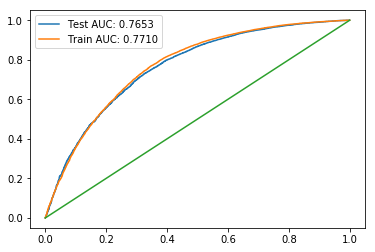

In [0]:
y_pred = model.predict([X_test_text, test_state, test_grade, test_cat, test_scat, test_tprefix, num_test]
                       , batch_size=2048)
y_pred_train = model.predict([X_train_text, train_state, train_grade, train_cat, train_scat, train_tprefix, num_train]
                       , batch_size=2048)


from sklearn.metrics import roc_curve
from matplotlib import pyplot as plot
aucts = roc_auc_score(y_test, y_pred)
print('Test AUC: %.4f' % aucts)
auctr = roc_auc_score(y_train, y_pred_train)
print('Train AUC: %.4f' % auctr)

# calculate roc curve
fprts, tprts, thresholds = roc_curve(y_test, y_pred)
fprtr, tprtr, thresholds = roc_curve(y_train, y_pred_train)
plot.plot(fprts, tprts, label='Test AUC: %.4f' % aucts)
plot.plot(fprtr, tprtr, label='Train AUC: %.4f' % auctr)
plot.plot([0,1], [0,1])
plot.legend(loc='upper left')
# show the plot
plot.show()

## 10.2 Model 2

Same model as Model 1, only difference is that we removed less important words from the text data.

We used idf values for each words to identify less important words.

<b>Process to identify less important words</b>
- use train data to train TfidfVectorizor
- get idf for each words
- get high-value and low-value thresholds using IQR boundries of idf values distribution
- build a list having idf more than higher threshold and less than lower threshold
- remove those words from train and test text


In [0]:
# replacing nan values with a white space
X_train.total_text.replace(np.nan,'', inplace=True)

In [0]:
from sklearn.feature_extraction.text import TfidfVectorizer
vect = TfidfVectorizer()
tfTrain=vect.fit_transform(X_train['total_text'])

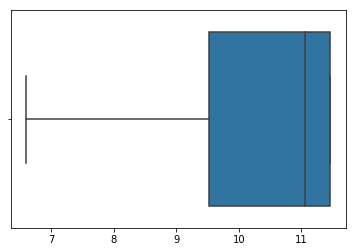

In [0]:
import seaborn as sns
sns.boxplot(vect.idf_, showfliers=False)

C:\Users\91814\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


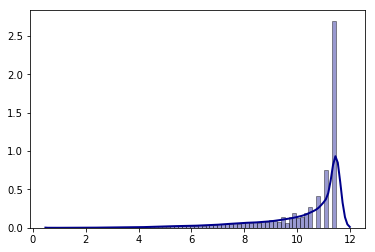

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.distplot(vect.idf_, hist=True, kde=True, 
             bins=int(70), color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2})

# inspecting percentile values
for i in range(11):
    print('{}th percentile idf value is {}'.format(i*10, np.percentile(vect.idf_, i*10)))

In [0]:
<b>By inspecting above idf values, we can see most of words (almost 50%) occur very few times.</b>

Thus choosing threshold based on IQR values would have very meaning less data (word occuring only once)and we would also loose some meaning ful details like frequently occuring words that do have importance.

<b>So we would choose 1.75 as a lower value threshold and 11.25 as a higher value threshold</b>

In [0]:
# build a list: words to be removed based on thresholds
from tqdm import tqdm_notebook as tqdm

less_imp_words=[]
j=0
for i in tqdm(vect.idf_):
    if i > 11.25 or i < 1.75:
        less_imp_words.append(vect.get_feature_names()[j])
    j=j+1

print("No. of less important words are {}".format(len(less_imp_words)))


No. of less important words are 20716


In [0]:
# ref: https://stackoverflow.com/questions/7356043/python-deleting-specific-strings-from-file

def remove_few_words(text):
    ntext=''
    for word in text.split():
        if word not in less_imp_words:
            ntext = ntext + ' ' + str(word)
    return ntext.strip()


In [0]:
X_train['new_total_text'] = X_train['total_text'].apply(lambda x: remove_few_words(x))

In [0]:
X_cv.total_text.replace(np.nan,'', inplace=True)
X_cv['new_total_text'] = X_cv['total_text'].apply(lambda x: remove_few_words(x))
print("-"*20)
X_test.total_text.replace(np.nan,'', inplace=True)
X_test['new_total_text'] = X_test['total_text'].apply(lambda x: remove_few_words(x))

--------------------


In [0]:
# ref: https://machinelearningmastery.com/use-word-embedding-layers-deep-learning-keras/

t2 = Tokenizer()
t2.fit_on_texts(X_train["new_total_text"].astype('str').tolist())
vocab_size = len(t2.word_index) + 1

print("Vocabulary size is {}".format(vocab_size))

Vocabulary size is 30616


In [0]:
len(X_train["new_total_text"][0].split())
new_text_len=[]
for ess in tqdm(X_train["new_total_text"]):
    new_text_len.append(len(ess.split()))

In [0]:
max(new_text_len)

320

In [0]:
tknText_train = t2.texts_to_sequences(X_train["new_total_text"].astype('str').tolist())
tknText_cv = t2.texts_to_sequences(X_cv["new_total_text"].astype('str').tolist())
tknText_test = t2.texts_to_sequences(X_test["new_total_text"].astype('str').tolist())
X_train_text = pad_sequences(tknText_train, maxlen=325, padding='post', truncating='post')
X_cv_text = pad_sequences(tknText_cv, maxlen=325, padding='post', truncating='post')
X_test_text = pad_sequences(tknText_test, maxlen=325, padding='post', truncating='post')

In [0]:
# load the whole embedding into memory
embeddings_index = dict()
f = open('glove.42B.300d.txt', encoding='utf8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Loaded %s word vectors.' % len(embeddings_index))

Loaded 1917494 word vectors.


In [0]:
# create a weight matrix for words in training docs
embedding_matrix = np.zeros((vocab_size, 300))
for word, i in t2.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
del embeddings_index

In [0]:

# School state feature encoding for embedding layer
from sklearn.preprocessing import StandardScaler
enc =Tokenizer()
enc.fit_on_texts(X_train['school_state'].values)
vocab_size_state = len(enc.word_index) + 1
train_state = enc.texts_to_sequences(X_train['school_state'].values)
cv_state = enc.texts_to_sequences(X_cv['school_state'].values)
test_state = enc.texts_to_sequences(X_test['school_state'].values)
train_state = pad_sequences(train_state, maxlen=1)
cv_state = pad_sequences(cv_state, maxlen=1)
test_state = pad_sequences(test_state, maxlen=1)


# project grade feature encoding for embedding layer
enc =Tokenizer()
enc.fit_on_texts(X_train['project_grade_category'].values)
vocab_size_grade = len(enc.word_index) + 1
train_grade = enc.texts_to_sequences(X_train['project_grade_category'].values)
cv_grade = enc.texts_to_sequences(X_cv['project_grade_category'].values)
test_grade = enc.texts_to_sequences(X_test['project_grade_category'].values)
train_grade = pad_sequences(train_grade, maxlen=1)
cv_grade = pad_sequences(cv_grade, maxlen=1)
test_grade = pad_sequences(test_grade, maxlen=1)

# project_subject_categories feature encoding for embedding layer
enc =Tokenizer()
enc.fit_on_texts(X_train['project_subject_categories'].values)
vocab_size_cat = len(enc.word_index) + 1
train_cat = enc.texts_to_sequences(X_train['project_subject_categories'].values)
cv_cat = enc.texts_to_sequences(X_cv['project_subject_categories'].values)
test_cat = enc.texts_to_sequences(X_test['project_subject_categories'].values)
train_cat = pad_sequences(train_cat, maxlen=8)
cv_cat = pad_sequences(cv_cat, maxlen=8)
test_cat = pad_sequences(test_cat, maxlen=8)

                         
# project_subject_subcategories feature encoding for embedding layer
enc =Tokenizer()
enc.fit_on_texts(X_train['project_subject_subcategories'].values)
vocab_size_scat = len(enc.word_index) + 1
train_scat = enc.texts_to_sequences(X_train['project_subject_subcategories'].values)
cv_scat = enc.texts_to_sequences(X_cv['project_subject_subcategories'].values)
test_scat = enc.texts_to_sequences(X_test['project_subject_subcategories'].values)
train_scat = pad_sequences(train_scat, maxlen=8)
cv_scat  = pad_sequences(cv_scat, maxlen=8)
test_scat  = pad_sequences(test_scat, maxlen=8)

# teacher_prefix feature encoding for embedding layer
enc =Tokenizer()
enc.fit_on_texts(X_train['teacher_prefix'].values)
vocab_size_tprefix = len(enc.word_index) + 1
train_tprefix = enc.texts_to_sequences(X_train['teacher_prefix'].values)
cv_tprefix = enc.texts_to_sequences(X_cv['teacher_prefix'].values)
test_tprefix = enc.texts_to_sequences(X_test['teacher_prefix'].values)
train_tprefix = pad_sequences(train_tprefix, maxlen=1)
test_tprefix = pad_sequences(test_tprefix, maxlen=1)
cv_tprefix = pad_sequences(cv_tprefix, maxlen=1)


In [0]:
# numerical features

numeric_ft = ["teacher_number_of_previously_posted_projects", "price", "quantity", "has_number_in_summary"]
scaler = StandardScaler()
num_train = scaler.fit_transform(X_train[numeric_ft])
num_test = scaler.transform(X_test[numeric_ft])
num_cv = scaler.transform(X_cv[numeric_ft])

In [0]:
# model  bulding
from keras.layers import concatenate, BatchNormalization, Dropout, Input, CuDNNLSTM, Bidirectional
from keras.models import Model
from keras import regularizers as rg

text_input = Input(shape=(325,), name='text_input')
x_text= Embedding(vocab_size, 300, weights=[embedding_matrix], input_length=325, trainable=False)(text_input)
x_text = CuDNNLSTM(16, return_sequences=True, kernel_regularizer=rg.l2())(x_text)
x_text = Flatten()(x_text)

state_input = Input(shape=(1,), name='state_input')
x_state= Embedding(vocab_size_state, 4)(state_input)
x_state = Flatten()(x_state)

grade_input = Input(shape=(1,), name='grade_input')
x_grade= Embedding(vocab_size_grade, 4)(grade_input)
x_grade = Flatten()(x_grade)

cat_input = Input(shape=(8,), name='cat_input')
x_cat= Embedding(vocab_size_cat, 16)(cat_input)
x_cat = Flatten()(x_cat)

scat_input = Input(shape=(8,), name='scat_input')
x_scat= Embedding(vocab_size_scat, 16)(scat_input)
x_scat = Flatten()(x_scat)

tprefix_input = Input(shape=(1,), name='tprefix_input')
x_tprefix= Embedding(vocab_size_tprefix, 4)(tprefix_input)
x_tprefix = Flatten()(x_tprefix)

num_input = Input(shape=(len(numeric_ft),), name='num_input')
x_num= Dense(8, activation='relu', kernel_initializer='he_normal')(num_input)

x = concatenate([x_text, x_state, x_grade, x_cat, x_scat, x_tprefix, x_num], name='concate')
x = BatchNormalization()(x)
x = Dropout(0.65)(x)

x = Dense(96, activation='relu', kernel_initializer='he_normal') (x)
x = BatchNormalization()(x)
x = Dropout(0.85)(x)

x = Dense(64, activation='relu', kernel_initializer='he_normal') (x)
x = BatchNormalization()(x)
x = Dropout(0.75)(x)

x = Dense(32, activation='relu', kernel_initializer='he_normal') (x)
x = BatchNormalization()(x)


out_put = Dense(1, activation='sigmoid') (x)

model = Model(inputs=[text_input, state_input, grade_input, cat_input, scat_input, tprefix_input, num_input],
              outputs=out_put)

model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
text_input (InputLayer)         (None, 325)          0                                            
__________________________________________________________________________________________________
embedding_49 (Embedding)        (None, 325, 300)     9184800     text_input[0][0]                 
__________________________________________________________________________________________________
state_input (InputLayer)        (None, 1)            0                                            
__________________________________________________________________________________________________
grade_input (InputLayer)        (None, 1)            0                                            
__________________________________________________________________________________________________
cat_input 

In [0]:
import tensorflow as tf
from sklearn.metrics import roc_auc_score
from keras import optimizers
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

def auroc(y_true, y_pred):
    return tf.py_func(roc_auc_score, (y_true, y_pred), tf.double)

model.compile(optimizer=optimizers.adam(0.003),
              loss='binary_crossentropy',
              metrics=[auroc])

In [0]:
from time import time
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint

tb = TensorBoard(log_dir= 'logs/model2/{}'.format(time()))
mcp_save = ModelCheckpoint('Arch2_bestModel.hdf5', save_best_only=True, monitor='val_auroc', mode='max')

batch_size = 512

model.fit([X_train_text, train_state, train_grade, train_cat, train_scat, train_tprefix, num_train],
          y_train, batch_size=batch_size, epochs=70, verbose=2, 
          validation_data=([X_cv_text, cv_state, cv_grade, cv_cat, cv_scat, cv_tprefix, num_cv], y_cv), 
          callbacks=[tb, mcp_save])

Train on 69918 samples, validate on 17480 samples
Epoch 1/70
 - 17s - loss: 0.6873 - auroc: 0.5072 - val_loss: 0.4351 - val_auroc: 0.5542
Epoch 2/70
 - 9s - loss: 0.4414 - auroc: 0.5280 - val_loss: 0.4362 - val_auroc: 0.6205
Epoch 3/70
 - 9s - loss: 0.4291 - auroc: 0.5909 - val_loss: 0.4409 - val_auroc: 0.6589
Epoch 4/70
 - 9s - loss: 0.4221 - auroc: 0.6341 - val_loss: 0.4130 - val_auroc: 0.6792
Epoch 5/70
 - 9s - loss: 0.4162 - auroc: 0.6553 - val_loss: 0.4266 - val_auroc: 0.6849
Epoch 6/70
 - 9s - loss: 0.4118 - auroc: 0.6678 - val_loss: 0.4025 - val_auroc: 0.6966
Epoch 7/70
 - 9s - loss: 0.4071 - auroc: 0.6866 - val_loss: 0.4417 - val_auroc: 0.6804
Epoch 8/70
 - 9s - loss: 0.4046 - auroc: 0.6954 - val_loss: 0.4419 - val_auroc: 0.7072
Epoch 9/70
 - 9s - loss: 0.3994 - auroc: 0.7072 - val_loss: 0.3962 - val_auroc: 0.7218
Epoch 10/70
 - 13s - loss: 0.3968 - auroc: 0.7113 - val_loss: 0.3930 - val_auroc: 0.7245
Epoch 11/70
 - 10s - loss: 0.3951 - auroc: 0.7108 - val_loss: 0.3974 - val_au

In [0]:
from keras.models import load_model
model = load_model('Arch2_bestModel.hdf5', custom_objects={'auroc':auroc})

Test AUC: 0.7627
Train AUC: 0.7763


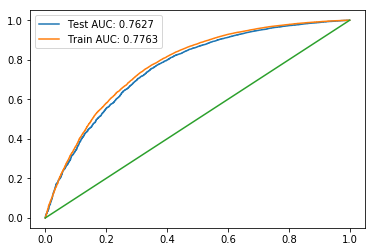

In [0]:
y_pred = model.predict([X_test_text, test_state, test_grade, test_cat, test_scat, test_tprefix, num_test]
                       , batch_size=2000)
y_pred_train = model.predict([X_train_text, train_state, train_grade, train_cat, train_scat, train_tprefix, num_train]
                       , batch_size=2000)


from sklearn.metrics import roc_curve
from matplotlib import pyplot as plot
aucts = roc_auc_score(y_test, y_pred)
print('Test AUC: %.4f' % aucts)
auctr = roc_auc_score(y_train, y_pred_train)
print('Train AUC: %.4f' % auctr)

# calculate roc curve
fprts, tprts, thresholds = roc_curve(y_test, y_pred)
fprtr, tprtr, thresholds = roc_curve(y_train, y_pred_train)
plot.plot(fprts, tprts, label='Test AUC: %.4f' % aucts)
plot.plot(fprtr, tprtr, label='Train AUC: %.4f' % auctr)
plot.plot([0,1], [0,1])
plot.legend(loc='upper left')
# show the plot
plot.show()

## 10.3 Model 3

<img src='https://i.imgur.com/fkQ8nGo.png'>

- __For text data:<br>
<pre>
    Same as model 1
</pre>
- __Other than text data:<br>
<pre>
    . Convert all your Categorical values to onehot coded and then concatenate all these onehot vectors <br>
    . Neumerical values and use CNN1D as shown in above figure. <br>
    
</pre>

In [0]:
# ref: https://machinelearningmastery.com/use-word-embedding-layers-deep-learning-keras/

t = Tokenizer()
t.fit_on_texts(X_train["total_text"].astype('str').tolist())
vocab_size = len(t.word_index) + 1

print("Vocabulary size is {}".format(vocab_size))

Vocabulary size is 51332


In [0]:
tknText_train = t.texts_to_sequences(X_train["total_text"].astype('str').tolist())
tknText_cv = t.texts_to_sequences(X_cv["total_text"].astype('str').tolist())
tknText_test = t.texts_to_sequences(X_test["total_text"].astype('str').tolist())
X_train_text = pad_sequences(tknText_train, maxlen=360, padding='post', truncating='post')
X_cv_text = pad_sequences(tknText_cv, maxlen=360, padding='post', truncating='post')
X_test_text = pad_sequences(tknText_test, maxlen=360, padding='post', truncating='post')

In [0]:
# load the whole embedding into memory
embeddings_index = dict()
f = open('glove.42B.300d.txt', encoding='utf8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Loaded %s word vectors.' % len(embeddings_index))

Loaded 1917494 word vectors.


In [0]:
# create a weight matrix for words in training docs
embedding_matrix = np.zeros((vocab_size, 300))
for word, i in t.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [0]:
# All other features, converting them to one hot encoding

# onehot encoding for categorical variables

from sklearn.feature_extraction.text import CountVectorizer
enc = CountVectorizer()
train_state_ohe = enc.fit_transform(X_train['school_state'])
cv_state_ohe = enc.transform(X_cv['school_state'])
test_state_ohe = enc.transform(X_test['school_state'])

enc = CountVectorizer()
train_grade_ohe = enc.fit_transform(X_train['project_grade_category'])
cv_grade_ohe = enc.transform(X_cv['project_grade_category'])
test_grade_ohe = enc.transform(X_test['project_grade_category'])

enc = CountVectorizer()
train_cat_ohe = enc.fit_transform(X_train['project_subject_categories'])
cv_cat_ohe = enc.transform(X_cv['project_subject_categories'])
test_cat_ohe = enc.transform(X_test['project_subject_categories'])

enc = CountVectorizer()
train_scat_ohe = enc.fit_transform(X_train['project_subject_subcategories'])
cv_scat_ohe = enc.transform(X_cv['project_subject_subcategories'])
test_scat_ohe = enc.transform(X_test['project_subject_subcategories'])

enc = CountVectorizer()
train_tp_ohe = enc.fit_transform(X_train['teacher_prefix'])
cv_tp_ohe = enc.transform(X_cv['teacher_prefix'])
test_tp_ohe = enc.transform(X_test['teacher_prefix'])


In [0]:
# numeric features
numeric_ft = ["teacher_number_of_previously_posted_projects", "price", "quantity", "has_number_in_summary"]
scaler = StandardScaler()
num_train = scaler.fit_transform(X_train[numeric_ft])
num_test = scaler.transform(X_test[numeric_ft])
num_cv = scaler.transform(X_cv[numeric_ft])

In [0]:
# combining all non text features
train_non_text =np.concatenate((train_state_ohe.toarray(), train_grade_ohe.toarray(), train_cat_ohe.toarray(), 
                                train_scat_ohe.toarray(), train_tp_ohe.toarray(), num_train), axis=1)
test_non_text =np.concatenate((test_state_ohe.toarray(), test_grade_ohe.toarray(), test_cat_ohe.toarray(), 
                                test_scat_ohe.toarray(), test_tp_ohe.toarray(), num_test), axis=1)
cv_non_text =np.concatenate((cv_state_ohe.toarray(), cv_grade_ohe.toarray(), cv_cat_ohe.toarray(), 
                                cv_scat_ohe.toarray(), cv_tp_ohe.toarray(), num_cv), axis=1)


In [0]:
train_non_text2 =np.expand_dims(train_non_text, -1)
test_non_text2 =np.expand_dims(test_non_text, -1)
cv_non_text2 =np.expand_dims(cv_non_text, -1)

In [0]:
train_non_text2.shape

(69918, 129, 1)

In [0]:
# model  bulding
from keras.layers import concatenate, BatchNormalization, Dropout, Input, Conv1D, MaxPooling1D
from keras.models import Model

text_input = Input(shape=(360,), name='text_input')
x_text= Embedding(vocab_size, 300, weights=[embedding_matrix], input_length=360, trainable=False)(text_input)
x_text = CuDNNLSTM(16, return_sequences=True, kernel_regularizer=rg.l2())(x_text)
x_text = Flatten()(x_text)

non_text_input = Input(shape=(129,1), name='non_text_input')
x_ntext= Conv1D(filters=64, kernel_size=5, activation='relu', kernel_initializer='he_normal')(non_text_input)
#x_ntext= MaxPooling1D(3)(x_ntext)
x_ntext= Conv1D(filters=32, kernel_size=8, activation='relu', kernel_initializer='he_normal')(x_ntext)
x_ntext= MaxPooling1D(2)(x_ntext)
x_ntext = Flatten()(x_ntext)

x = concatenate([x_text, x_ntext], name='concate')
x = BatchNormalization()(x)
x = Dropout(0.7)(x)

x = Dense(96, activation='relu', kernel_initializer='he_normal') (x)
x = BatchNormalization()(x)
x = Dropout(0.85)(x)

x = Dense(64, activation='relu', kernel_initializer='he_normal') (x)
x = BatchNormalization()(x)
x = Dropout(0.75)(x)

x = Dense(32, activation='relu', kernel_initializer='he_normal') (x)
x = BatchNormalization()(x)


out_put = Dense(1, activation='sigmoid') (x)

model = Model(inputs=[text_input, non_text_input],
              outputs=out_put)

model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
non_text_input (InputLayer)     (None, 129, 1)       0                                            
__________________________________________________________________________________________________
text_input (InputLayer)         (None, 360)          0                                            
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 125, 64)      384         non_text_input[0][0]             
__________________________________________________________________________________________________
embedding_55 (Embedding)        (None, 360, 300)     15399600    text_input[0][0]                 
__________________________________________________________________________________________________
conv1d_2 (

In [0]:
import tensorflow as tf
from sklearn.metrics import roc_auc_score
from keras import optimizers
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

def auroc(y_true, y_pred):
    return tf.py_func(roc_auc_score, (y_true, y_pred), tf.double)

model.compile(optimizer=optimizers.adam(0.001, decay=1e-6),
              loss='binary_crossentropy',
              metrics=[auroc])

In [0]:
from time import time
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint

tb = TensorBoard(log_dir= 'logs/model3/{}'.format(time()))
mcp_save = ModelCheckpoint('Arch3_bestModel.hdf5', save_best_only=True, monitor='val_auroc', mode='max')

batch_size = 512

model.fit([X_train_text, train_non_text2],y_train, validation_data=([X_cv_text, cv_non_text2], y_cv),
           batch_size=batch_size, epochs=70, verbose=2, callbacks=[tb, mcp_save])

Train on 69918 samples, validate on 17480 samples
Epoch 1/70
 - 31s - loss: 1.0141 - auroc: 0.5074 - val_loss: 0.5489 - val_auroc: 0.5380
Epoch 2/70
 - 16s - loss: 0.4872 - auroc: 0.5054 - val_loss: 0.4356 - val_auroc: 0.5391
Epoch 3/70
 - 17s - loss: 0.4410 - auroc: 0.5176 - val_loss: 0.4259 - val_auroc: 0.5680
Epoch 4/70
 - 16s - loss: 0.4348 - auroc: 0.5293 - val_loss: 0.4344 - val_auroc: 0.5686
Epoch 5/70
 - 29s - loss: 0.4309 - auroc: 0.5474 - val_loss: 0.4609 - val_auroc: 0.5825
Epoch 6/70
 - 15s - loss: 0.4242 - auroc: 0.5971 - val_loss: 0.4386 - val_auroc: 0.6412
Epoch 7/70
 - 15s - loss: 0.4155 - auroc: 0.6431 - val_loss: 0.4455 - val_auroc: 0.6864
Epoch 8/70
 - 14s - loss: 0.4109 - auroc: 0.6599 - val_loss: 0.4001 - val_auroc: 0.6994
Epoch 9/70
 - 15s - loss: 0.4061 - auroc: 0.6781 - val_loss: 0.3954 - val_auroc: 0.7083
Epoch 10/70
 - 13s - loss: 0.4031 - auroc: 0.6870 - val_loss: 0.4091 - val_auroc: 0.7152
Epoch 11/70
 - 13s - loss: 0.3994 - auroc: 0.6982 - val_loss: 0.3970 

In [0]:
from keras.models import load_model
model = load_model('Arch3_bestModel.hdf5', custom_objects={'auroc':auroc})

Test AUC: 0.7707
Train AUC: 0.7864


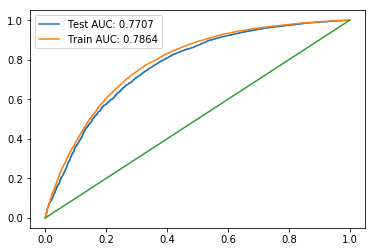

In [0]:
y_pred = model.predict([X_test_text, test_non_text2], batch_size=2000)
y_pred_train = model.predict([X_train_text, train_non_text2], batch_size=2000)


from sklearn.metrics import roc_curve
from matplotlib import pyplot as plot
aucts = roc_auc_score(y_test, y_pred)
print('Test AUC: %.4f' % aucts)
auctr = roc_auc_score(y_train, y_pred_train)
print('Train AUC: %.4f' % auctr)

# calculate roc curve
fprts, tprts, thresholds = roc_curve(y_test, y_pred)
fprtr, tprtr, thresholds = roc_curve(y_train, y_pred_train)
plot.plot(fprts, tprts, label='Test AUC: %.4f' % aucts)
plot.plot(fprtr, tprtr, label='Train AUC: %.4f' % auctr)
plot.plot([0,1], [0,1])
plot.legend(loc='upper left')
# show the plot
plot.show()

# 11. Tensorboard vizualization

<h3>epoch-wise AUC (Training)</h3>

![TB_training_auc.png](attachment:TB_training_auc.png)

<h3>epoch-wise AUC (Validation)</h3>

![TB_validation_auc.png](attachment:TB_validation_auc.png)


# 12. Conclusion

In [0]:
from prettytable import PrettyTable
    
x = PrettyTable()

x.field_names = ["Model", "Train AUC", "Test AUC"]

x.add_row(["Model 1", .771, .765])
x.add_row(["Model 2", .776, .763])
x.add_row(["Model 3", .786, .771])

print(x)


+---------+-----------+----------+
|  Model  | Train AUC | Test AUC |
+---------+-----------+----------+
| Model 1 |   0.771   |  0.765   |
| Model 2 |   0.776   |  0.763   |
| Model 3 |   0.786   |  0.771   |
+---------+-----------+----------+
